In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Importing the Libraries

In [60]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from kerastuner.tuners import RandomSearch
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# 2. Prepare the Dataset

In [61]:
TRAINING_DIR = '/content/drive/My Drive/Maleria/cell_images/'

# training data generator with data augmentation

training_datagen = ImageDataGenerator(
     rescale = 1./255,
     shear_range = 0.2,
     zoom_range = 0.2,
     horizontal_flip = True,
     validation_split=0.2)

# validation data generator without data augmentation

validate_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.2)
train_generator= training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
  subset='training',
  seed=1
)

validation_generator= validate_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
  subset='validation',
  seed=1,
  shuffle=False
)

train_generator.class_indices

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


{'Parasitized': 0, 'Uninfected': 1}

# 3. Visualize the dataset

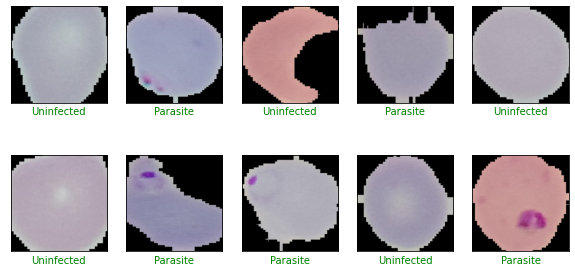

In [ ]:
class_names = ['Parasite','Uninfected']
x_train,y_train=next(train_generator)
#image visualization
def show_random_examples(x,y,p):
    indices=np.random.choice(range(x.shape[0]),10,replace=False)
    x=x[indices]
    y=y[indices]
    p=p[indices]
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col='green' if np.argmax(y[i])==np.argmax(p[i]) else 'red'
        np.argmax(p[i])
        plt.xlabel(class_names[np.argmax(p[i])],color=col)
    plt.show()
show_random_examples(x_train,y_train,y_train)

# 4. Prepare the Model

In [ ]:
def build_model(hp):
  model=Sequential()
  model.add(Conv2D(filters=hp.Int('Conv_1_filter',min_value=16,max_value=128),
                   kernel_size=hp.Choice('conv_1_kernel',values=[3,5]),
                   padding="same",activation="relu",input_shape=(224,224,3)))
  model.add(MaxPooling2D(pool_size=hp.Choice('maxpool_1_kernel',values=[2,3,5])))
  model.add(Conv2D(filters=hp.Int('Conv_2_filter',min_value=32,max_value=128),
                   kernel_size=hp.Choice('conv_2_kernel',values=[3,5]),
                   padding="same",activation="relu"))
  model.add(MaxPooling2D(pool_size=hp.Choice('maxpool_2_kernel',values=[2,3,5])))
  model.add(Conv2D(filters=hp.Int('Conv_3_filter',min_value=64,max_value=128),
                   kernel_size=hp.Choice('conv_3_kernel',values=[3,5]),
                   padding="same",activation="relu"))
  model.add(MaxPooling2D(pool_size=hp.Choice('maxpool_2_kernel',values=[2,3,5])))
  model.add(Flatten())
  model.add(Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu'))
  model.add(Dense(2,activation="softmax"))

  model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
    metrics=['accuracy']
  )
  return model


In [ ]:
from kerastuner.engine.hyperparameters import HyperParameters
tuner_search=RandomSearch(build_model,objective='val_accuracy',max_trials=5)
tuner_search.search(train_generator,epochs=3,validation_data=validation_generator)

Epoch 1/3
689/689 [==============================] - 349s 507ms/step - loss: 0.4422 - accuracy: 0.7890 - val_loss: 0.2194 - val_accuracy: 0.9178
Epoch 2/3
689/689 [==============================] - 345s 501ms/step - loss: 0.1790 - accuracy: 0.9420 - val_loss: 0.2038 - val_accuracy: 0.9383
Epoch 3/3
689/689 [==============================] - 346s 502ms/step - loss: 0.1572 - accuracy: 0.9514 - val_loss: 0.1853 - val_accuracy: 0.9377


Epoch 1/3
689/689 [==============================] - 336s 488ms/step - loss: 0.6087 - accuracy: 0.6606 - val_loss: 0.4803 - val_accuracy: 0.8000
Epoch 2/3
689/689 [==============================] - 337s 489ms/step - loss: 0.2599 - accuracy: 0.9039 - val_loss: 0.2052 - val_accuracy: 0.9134
Epoch 3/3
689/689 [==============================] - 330s 479ms/step - loss: 0.1701 - accuracy: 0.9431 - val_loss: 0.2291 - val_accuracy: 0.9080


Epoch 1/3
689/689 [==============================] - 334s 484ms/step - loss: 0.5329 - accuracy: 0.7216 - val_loss: 0.2613 - val_accuracy: 0.9143
Epoch 2/3
689/689 [==============================] - 336s 488ms/step - loss: 0.2255 - accuracy: 0.9170 - val_loss: 0.2124 - val_accuracy: 0.9289
Epoch 3/3
689/689 [==============================] - 334s 485ms/step - loss: 0.1863 - accuracy: 0.9372 - val_loss: 0.2120 - val_accuracy: 0.9358


Epoch 1/3
689/689 [==============================] - 340s 494ms/step - loss: 0.4811 - accuracy: 0.7739 - val_loss: 0.2916 - val_accuracy: 0.9004
Epoch 2/3
689/689 [==============================] - 330s 479ms/step - loss: 0.2139 - accuracy: 0.9304 - val_loss: 0.2068 - val_accuracy: 0.9330
Epoch 3/3
689/689 [==============================] - 330s 479ms/step - loss: 0.1634 - accuracy: 0.9489 - val_loss: 0.1798 - val_accuracy: 0.9381


Epoch 1/3
689/689 [==============================] - 339s 492ms/step - loss: 0.4856 - accuracy: 0.7363 - val_loss: 0.2285 - val_accuracy: 0.9250
Epoch 2/3
689/689 [==============================] - 336s 488ms/step - loss: 0.1898 - accuracy: 0.9419 - val_loss: 0.1933 - val_accuracy: 0.9416
Epoch 3/3
689/689 [==============================] - 327s 474ms/step - loss: 0.1515 - accuracy: 0.9540 - val_loss: 0.1679 - val_accuracy: 0.9436


INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 122)     3416      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 122)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 100)       109900    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 111)       100011    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 111)       0         
_________________________________________________________________
flatten (Flatten)            (None, 35964)             0

In [ ]:
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=25,
  initial_epoch=3,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator),
  callbacks=[tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Maleria/resenet_{val_accuracy:.3f}.h5',
                                                  save_best_only=True,save_weights_only=False,monitor='val_accuracy')]
)

Epoch 4/25
689/689 [==============================] - 361s 524ms/step - loss: 0.1386 - accuracy: 0.9568 - val_loss: 0.1777 - val_accuracy: 0.9328
Epoch 5/25
689/689 [==============================] - 361s 524ms/step - loss: 0.1287 - accuracy: 0.9595 - val_loss: 0.1772 - val_accuracy: 0.9410
Epoch 6/25
689/689 [==============================] - 365s 530ms/step - loss: 0.1256 - accuracy: 0.9606 - val_loss: 0.1471 - val_accuracy: 0.9432
Epoch 7/25
689/689 [==============================] - 366s 531ms/step - loss: 0.1191 - accuracy: 0.9619 - val_loss: 0.2057 - val_accuracy: 0.9456
Epoch 8/25
689/689 [==============================] - 361s 524ms/step - loss: 0.1157 - accuracy: 0.9623 - val_loss: 0.1497 - val_accuracy: 0.9485
Epoch 9/25
689/689 [==============================] - 356s 517ms/step - loss: 0.1120 - accuracy: 0.9637 - val_loss: 0.1530 - val_accuracy: 0.9490
Epoch 10/25
689/689 [==============================] - 340s 493ms/step - loss: 0.1103 - accuracy: 0.9631 - val_loss: 0.1496 

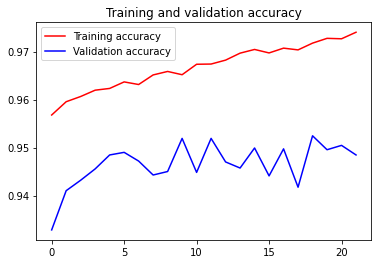

<Figure size 432x288 with 0 Axes>

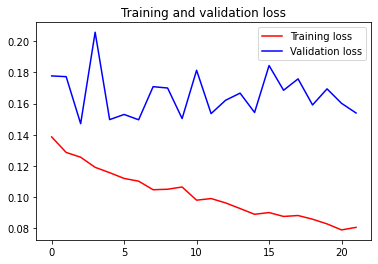

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [62]:
model=tf.keras.models.load_model('/content/drive/My Drive/Maleria/resenet_0.952.h5')

In [113]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
results_valid = model.evaluate(validation_generator)
print("\nValidation loss : "+"{:.2f}".format(results_valid[0]),"  Validation accuracy : "+"{:.2f}".format(results_valid[1]))
pred=model.predict(validation_generator)
pred = np.argmax(pred, axis=1)
class_names = ['Parasite','Uninfected']
print('\nConfusion Matrix')
print(confusion_matrix(validation_generator.classes,pred))
print('Classification Report')
print(classification_report(validation_generator.classes,pred, target_names=class_names))
print(accuracy_score(validation_generator.classes,pred))

173/173 [==============================] - 64s 368ms/step - loss: 0.1657 - accuracy: 0.9512

Validation loss : 0.17   Validation accuracy : 0.95

Confusion Matrix
[[2594  161]
 [ 108 2647]]
Classification Report
              precision    recall  f1-score   support

    Parasite       0.96      0.94      0.95      2755
  Uninfected       0.94      0.96      0.95      2755

    accuracy                           0.95      5510
   macro avg       0.95      0.95      0.95      5510
weighted avg       0.95      0.95      0.95      5510

0.9511796733212341


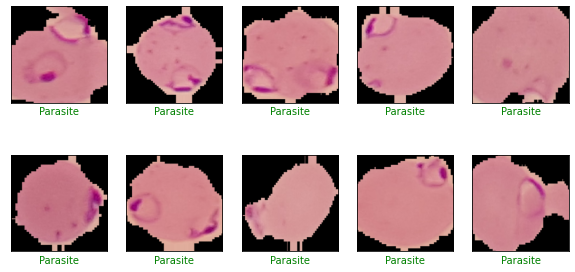

In [112]:
# Green correct prediction, Red wrong prediction
x_train,y_train=next(validation_generator)
show_random_examples(x_train,y_train,pred)

Saving C3thin_original_IMG_20150608_163029_cell_57.png to C3thin_original_IMG_20150608_163029_cell_57.png


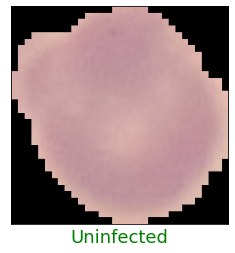

In [65]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = fn
  img = image.load_img(path,color_mode="rgb",target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x/255.])
  pred = model.predict(images, batch_size=6)
  plt.imshow(img)
  plt.xticks([])
  plt.yticks([])
  #print (np.argmax(p[i]))
  plt.xlabel(class_names[np.argmax(pred)],color='green',fontsize=18)
plt.show()